# social.coop Registrations

Whenever someone registers for a new account at https://wiki.social.coop/registration-form.html a Gitlab issue is automatically created for someone from the community working group to process. Since each issue has a `created_time` we can take a quick look at social.coop registrations over time. I guess this information is also in the Mastodon database itself...

To run this notebook you'll need to install a few things:

```
pip install -r requirements.txt
```

Then you'll need to add a `.env` file that contains your GitLab API token:

```
GITLAB_TOKEN=YOURTOKENHERE
```

Then you can run this code to fetch the issues from the (private) [community-operations](https://git.coop/social.coop/community/operations/-/issues) repository:

In [1]:
import os
import json
import time
import dotenv
import requests

dotenv.load_dotenv()

token = os.environ.get('GITLAB_TOKEN')

page = 1
issues = []
while True:
    resp = requests.get("https://git.coop/api/v4/projects/764/issues", headers={"PRIVATE-TOKEN": token}, params={"page": page, "per_page": 100})
    results = resp.json()

    if len(results) == 0:
        break

    issues.extend(results)
    time.sleep(.5)
    page += 1

json.dump(issues, open("data/issues.json", "w"), indent=2)


Now you can load in the issues data into a Pandas DataFrame, and extract out just the issues that are related to new registrations. These issues are created automatically by the registration process.

In [2]:
import pandas

df = pandas.read_json('data/issues.json', convert_dates=True)
df = df[df.title.str.match('social.coop registration')]
df = df.set_index('created_at')


Now we can resample the created_at index grouping by week:

In [3]:
counts = df.resample('W').count()
counts.head()

id  iid  project_id  title  description  state  \
created_at                                                                  
2021-02-28 00:00:00+00:00   1    1           1      1            1      1   
2021-03-07 00:00:00+00:00   5    5           5      5            5      5   
2021-03-14 00:00:00+00:00   8    8           8      8            8      8   
2021-03-21 00:00:00+00:00   2    2           2      2            2      2   
2021-03-28 00:00:00+00:00   6    6           6      6            6      6   

                           updated_at  closed_at  closed_by  labels  ...  \
created_at                                                           ...   
2021-02-28 00:00:00+00:00           1          1          1       1  ...   
2021-03-07 00:00:00+00:00           5          5          5       5  ...   
2021-03-14 00:00:00+00:00           8          8          8       8  ...   
2021-03-21 00:00:00+00:00           2          2          2       2  ...   
2021-03-28 00:00:00+00:00           6          6          6       6  ...   

                           web_url  time_stats  task_completion_status  \
created_at                                                               
2021-02-28 00:00:00+00:00        1           1                       1   
2021-03-07 00:00:00+00:00        5           5                       5   
2021-03-14 00:00:00+00:00        8           8                       8   
2021-03-21 00:00:00+00:00        2           2                       2   
2021-03-28 00:00:00+00:00        6           6                       6   

                           has_tasks  task_status  _links  references  \
created_at                                                              
2021-02-28 00:00:00+00:00          1            1       1           1   
2021-03-07 00:00:00+00:00          5            5       5           5   
2021-03-14 00:00:00+00:00          8            8       8           8   
2021-03-21 00:00:00+00:00          2            2       2           2   
2021-03-28 00:00:00+00:00          6            6       6           6   

                           severity  moved_to_id  service_desk_reply_to  
created_at                                                               
2021-02-28 00:00:00+00:00         1            0                      0  
2021-03-07 00:00:00+00:00         5            0                      0  
2021-03-14 00:00:00+00:00         8            0                      0  
2021-03-21 00:00:00+00:00         2            0                      0  
2021-03-28 00:00:00+00:00         6            0                      0  

[5 rows x 33 columns]

And graph the weekly registrations:

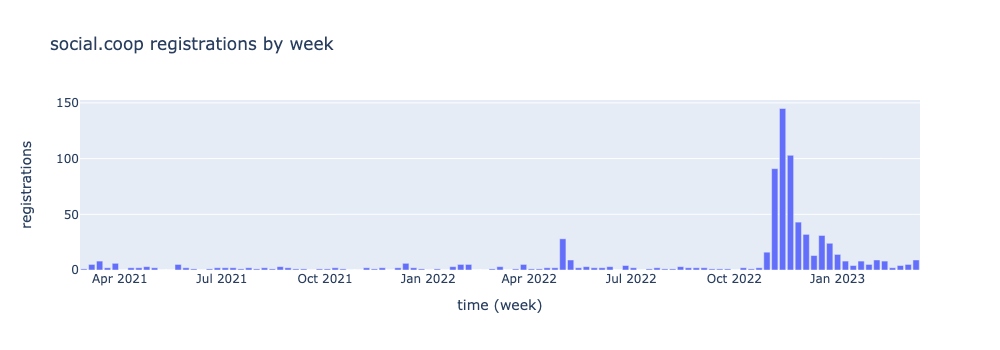

In [4]:
import plotly.express as xp

fig = xp.bar(counts, x=counts.index, y=counts.id, title='social.coop registrations by week', labels={'id': 'registrations', 'created_at': 'time (week)'})
fig.show("png", width=1000, height=350)

Daily registrations:

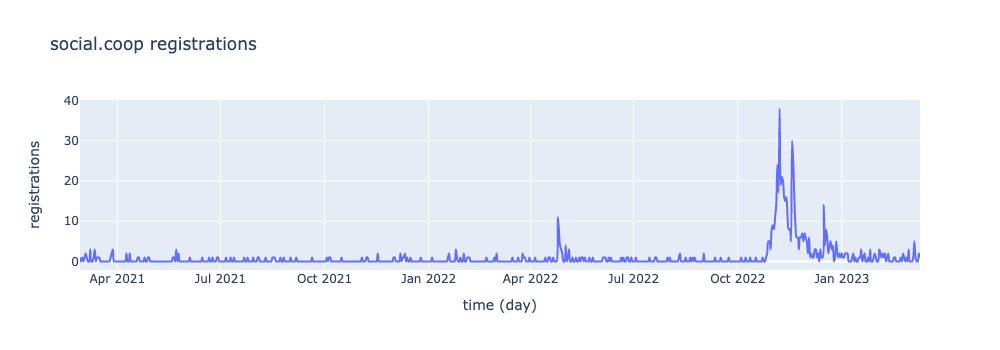

In [5]:
counts = df.resample('D').count()
fig = xp.line(counts, x=counts.index, y=counts.id, title='social.coop registrations', labels={'id': 'registrations', 'created_at': 'time (day)'}, line_shape="spline")
fig.show("png", width=1000, height=350)

Monthly registrations:

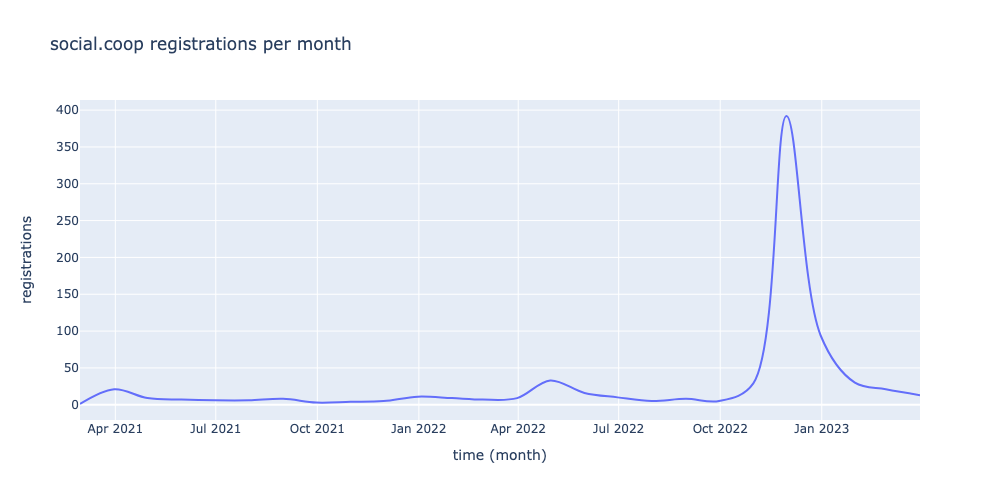

In [6]:
counts = df.resample('M').count()
fig = xp.line(counts, x=counts.index, y=counts.id, title='social.coop registrations per month', labels={'id': 'registrations', 'created_at': 'time (month)'}, line_shape="spline")
fig.show("png", width=1000)

## Word Cloud

When people sign up they write a few sentences about themselves. This is embedded in the issue text as a chunk of JSON which we can parse out, and use to create a word cloud.

In [14]:
import re
import json

def about(desc):
    m = re.search(r'```(.+)```', desc, re.DOTALL)
    reg = json.loads(m.group(1))
    return reg['about-me']
    
df['about'] = df.description.apply(about)
df['about']

created_at
2022-12-21 17:34:23.650000+00:00    I'm just exploring federated social networks, ...
2022-12-21 17:30:31.530000+00:00    I'm an engineering student researching commoni...
2022-12-20 20:17:33.162000+00:00    DecentSocial is an online unconference for the...
2022-12-20 17:17:56.725000+00:00    I mostly use social media to share my open-sou...
2022-12-19 17:10:27.526000+00:00    CEO of INCA.coop trade association for the UK ...
                                                          ...                        
2021-03-04 17:08:42.631000+00:00    I want to interact with people and learn more ...
2021-03-04 02:09:34.664000+00:00    After a long hiatus from all social media I ha...
2021-03-03 23:37:03.102000+00:00    Hello! I'm a computer science student at UW-Ma...
2021-03-01 17:41:56.165000+00:00    I am committed to de-centralising world food s...
2021-02-27 22:21:00.314000+00:00                                              testing
Name: about, Length: 672, dtype: object

Clean the data, lowercasing, removing stopwords and lemmatizing (e.g. computers -> computer):

In [22]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download(['wordnet', 'omw-1.4', 'stopwords'], quiet=True)
lem = WordNetLemmatizer()

stops = set(stopwords.words("english"))
stops.add('http')
stops.add('twitter')

def clean(s):
    s = s.lower()
    words = word_tokenize(s)
    words = [lem.lemmatize(w).strip() for w in words if w not in stops]
    words = [w for w in words if not re.search(r'''[,\'":,.`@#$%^!&*?()_+":{}|\[\]\\’\-]''', w)]
    return ' '.join(words)

df['about_clean'] = df.about.apply(clean)
df['about_clean']

created_at
2022-12-21 17:34:23.650000+00:00    exploring federated social network interested ...
2022-12-21 17:30:31.530000+00:00    engineering student researching commoning hard...
2022-12-20 20:17:33.162000+00:00    decentsocial online unconference builder decen...
2022-12-20 17:17:56.725000+00:00    mostly use social medium share work interact m...
2022-12-19 17:10:27.526000+00:00    ceo trade association uk altnets internet doma...
                                                          ...                        
2021-03-04 17:08:42.631000+00:00    want interact people learn social cooperative ...
2021-03-04 02:09:34.664000+00:00    long hiatus social medium decided time give an...
2021-03-03 23:37:03.102000+00:00    hello computer science student entrepreneur cu...
2021-03-01 17:41:56.165000+00:00    committed world food system need tool common o...
2021-02-27 22:21:00.314000+00:00                                              testing
Name: about_clean, Length: 672, dtype: obje

Count the words:

In [23]:
counts = df['about_clean'].str.split().apply(pandas.value_counts)
counts = counts.sum()
counts = counts.sort_values(ascending=False)
counts[0:100]


community      273.0
like           256.0
social         234.0
cooperative    219.0
interested     178.0
               ...  
common          31.0
form            31.0
group           30.0
need            30.0
democratic      30.0
Length: 100, dtype: float64

Throw the word frequencies at the wordcloud library!

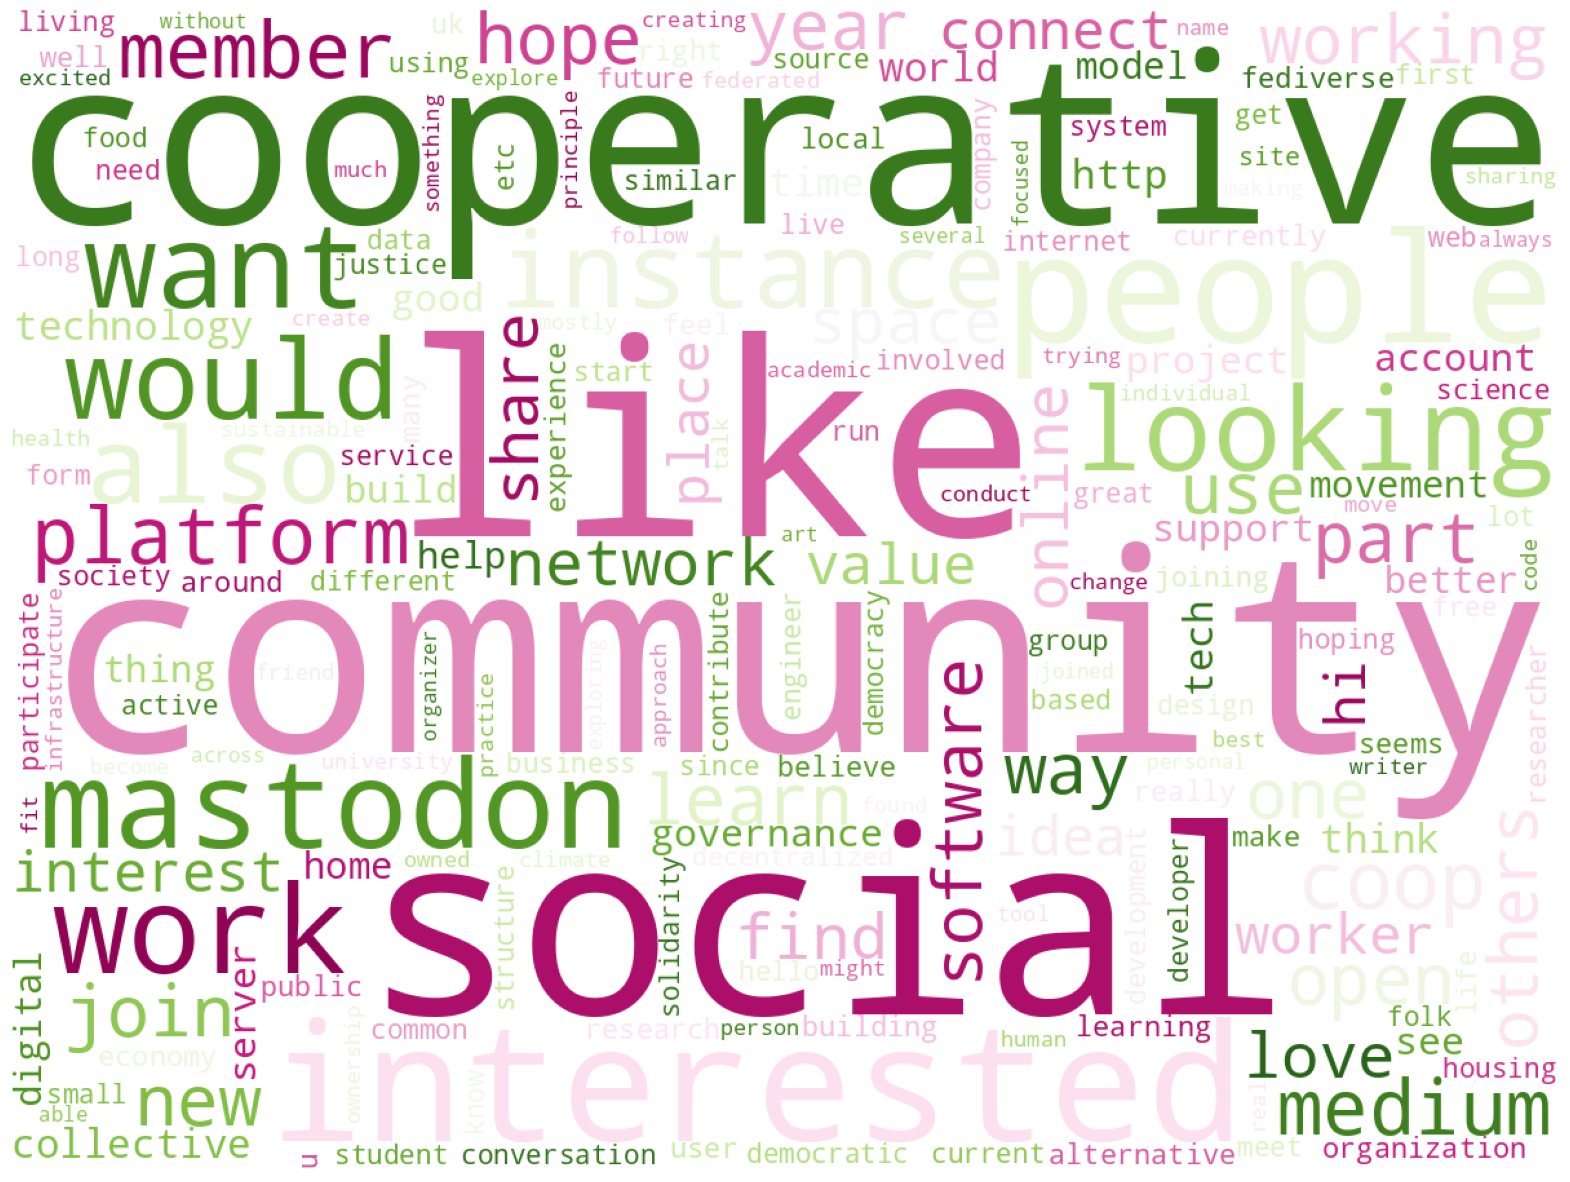

In [24]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

def generate_basic_wordcloud(data, mask=None, max_words=200, contour_width=0, colormap='PiYG', height=900, width=1200, background_color="white"):
    cloud = WordCloud(width=width,
                      height=height,
                      max_words=max_words,
                      mask=mask,
                      contour_width=contour_width,
                      colormap=colormap,
                      background_color=background_color,
                      min_font_size=6,
                      stopwords=stopwords,
                      min_word_length=3,
                      collocations=True).generate_from_frequencies(data)
    plt.figure(figsize=(20,16))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
    
generate_basic_wordcloud(counts)

Try using the social.coop logo as an image mask:

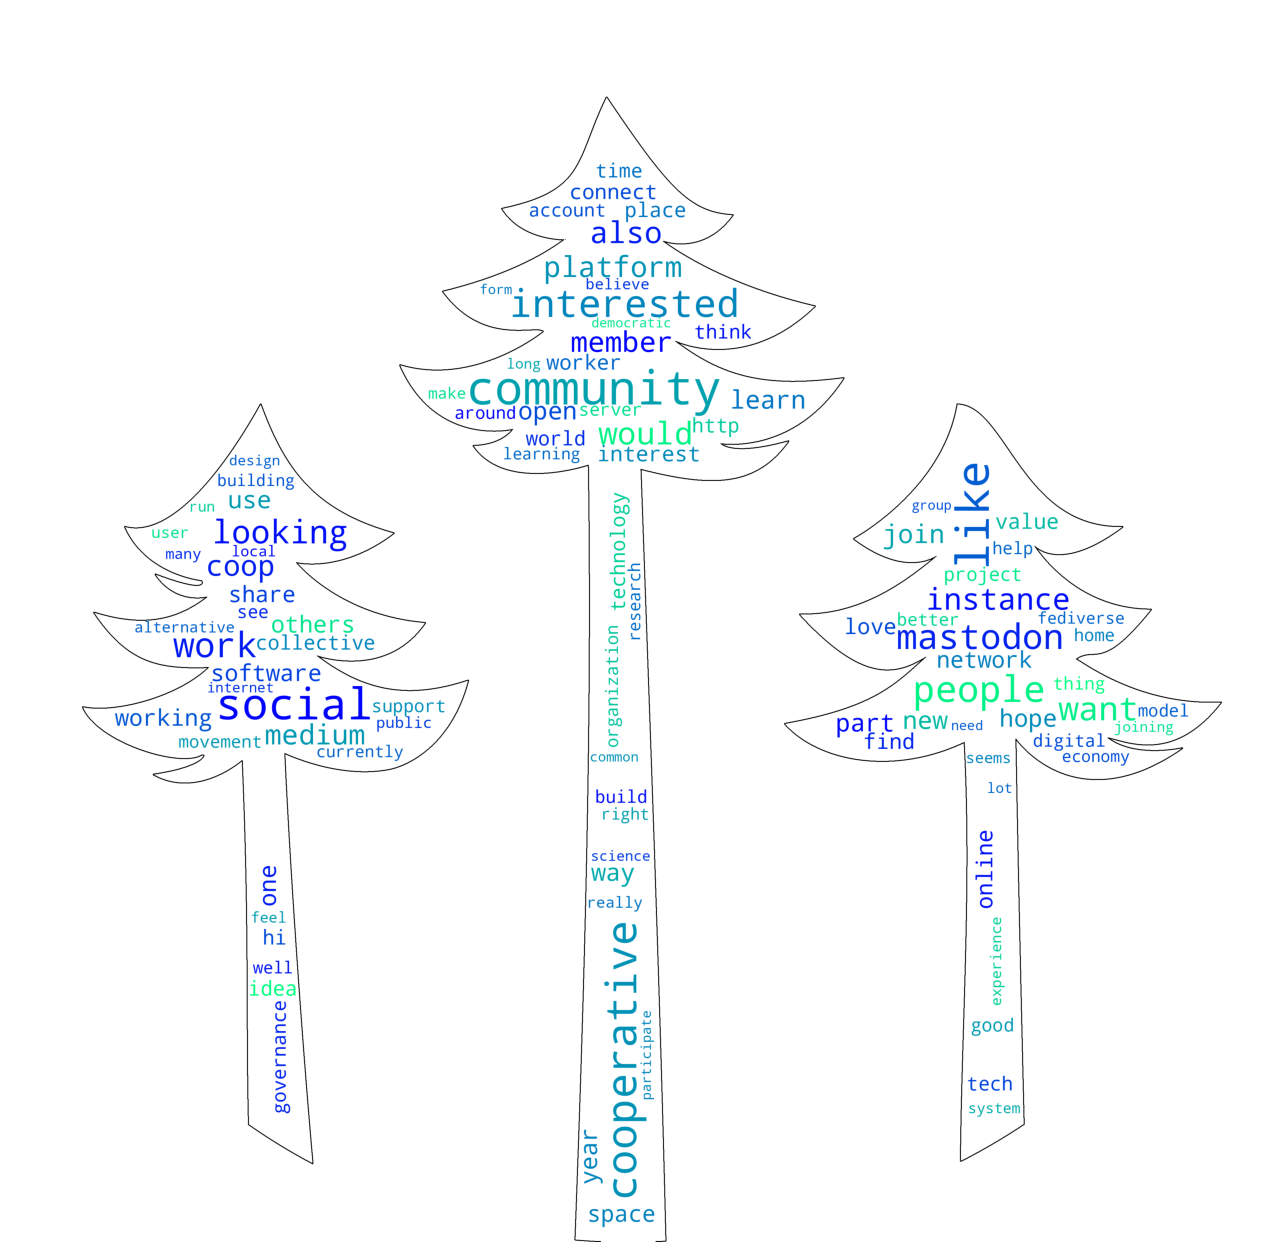

In [25]:
mask = np.array(Image.open('images/social-coop-logo-inverted.png'))
generate_basic_wordcloud(counts, mask=mask, max_words=100, contour_width=2, colormap='winter')

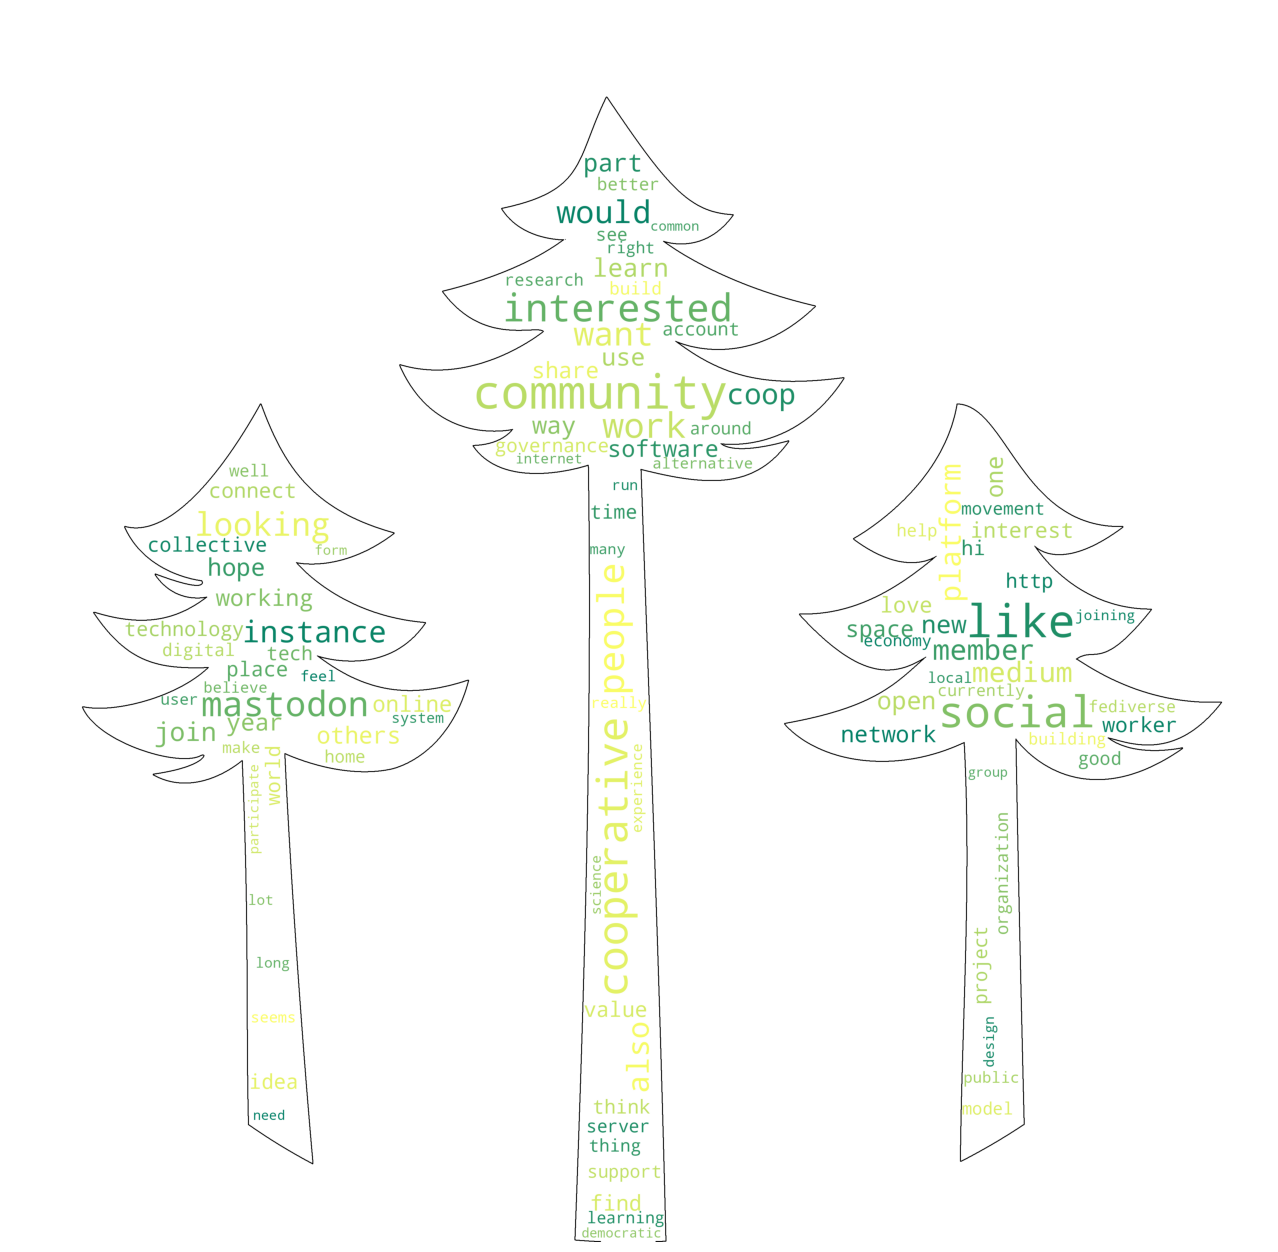

In [26]:
generate_basic_wordcloud(counts, mask=mask, max_words=100, contour_width=2, colormap='summer')

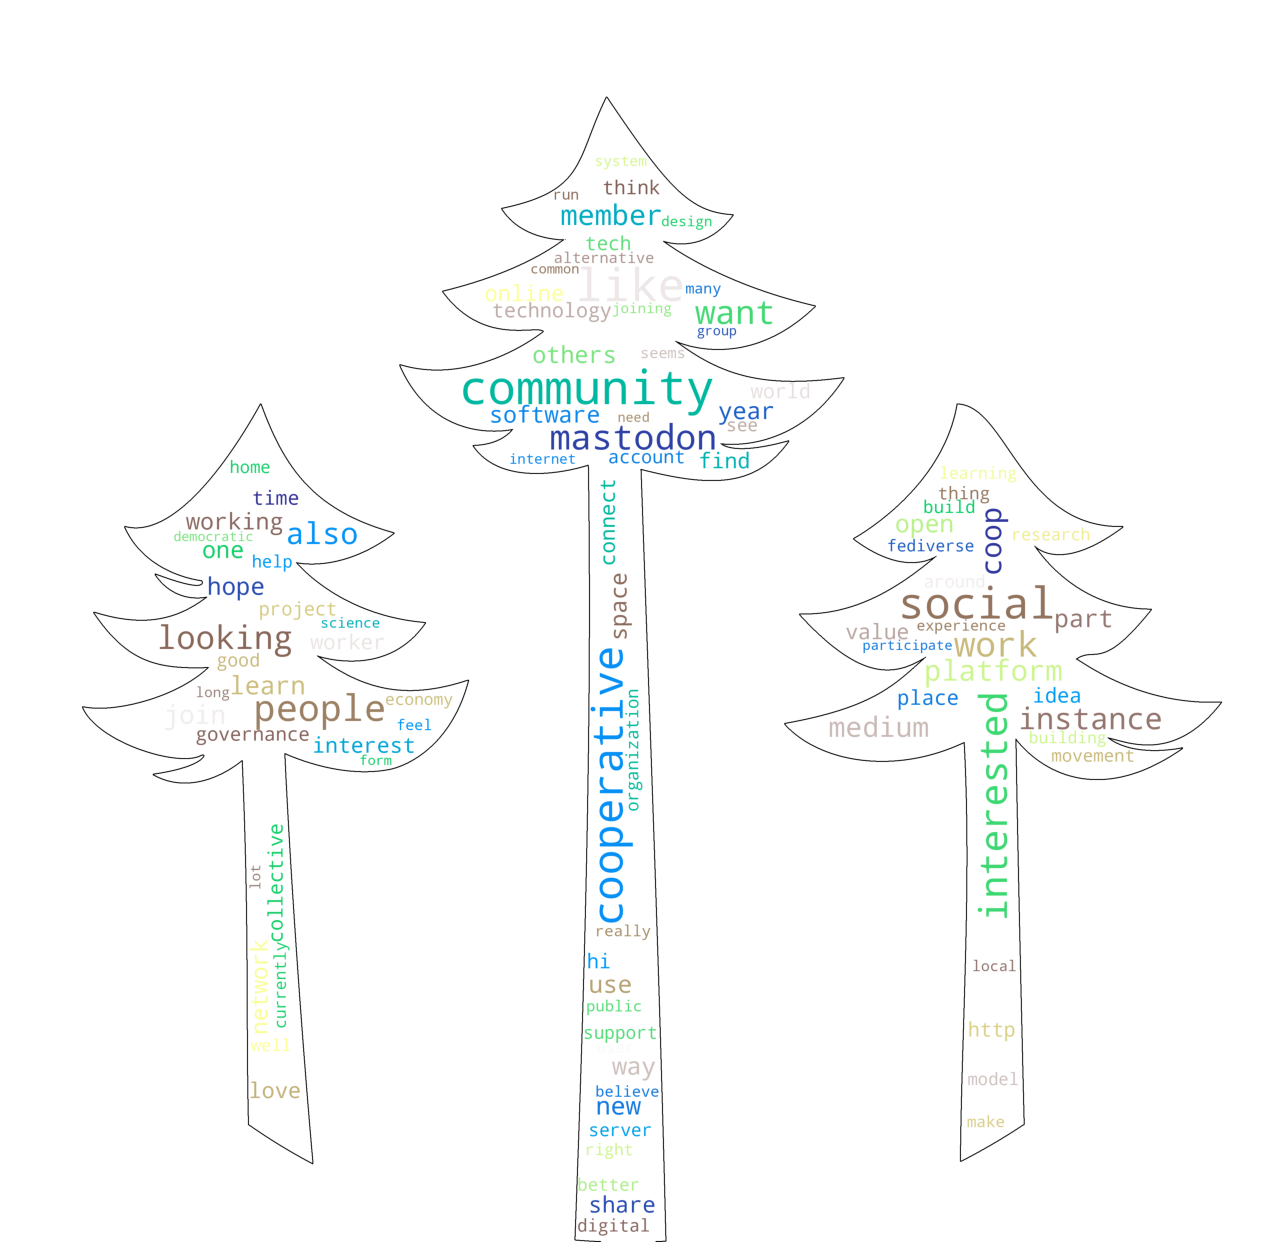

In [27]:
generate_basic_wordcloud(counts, mask=mask, max_words=100, contour_width=2, colormap='terrain')

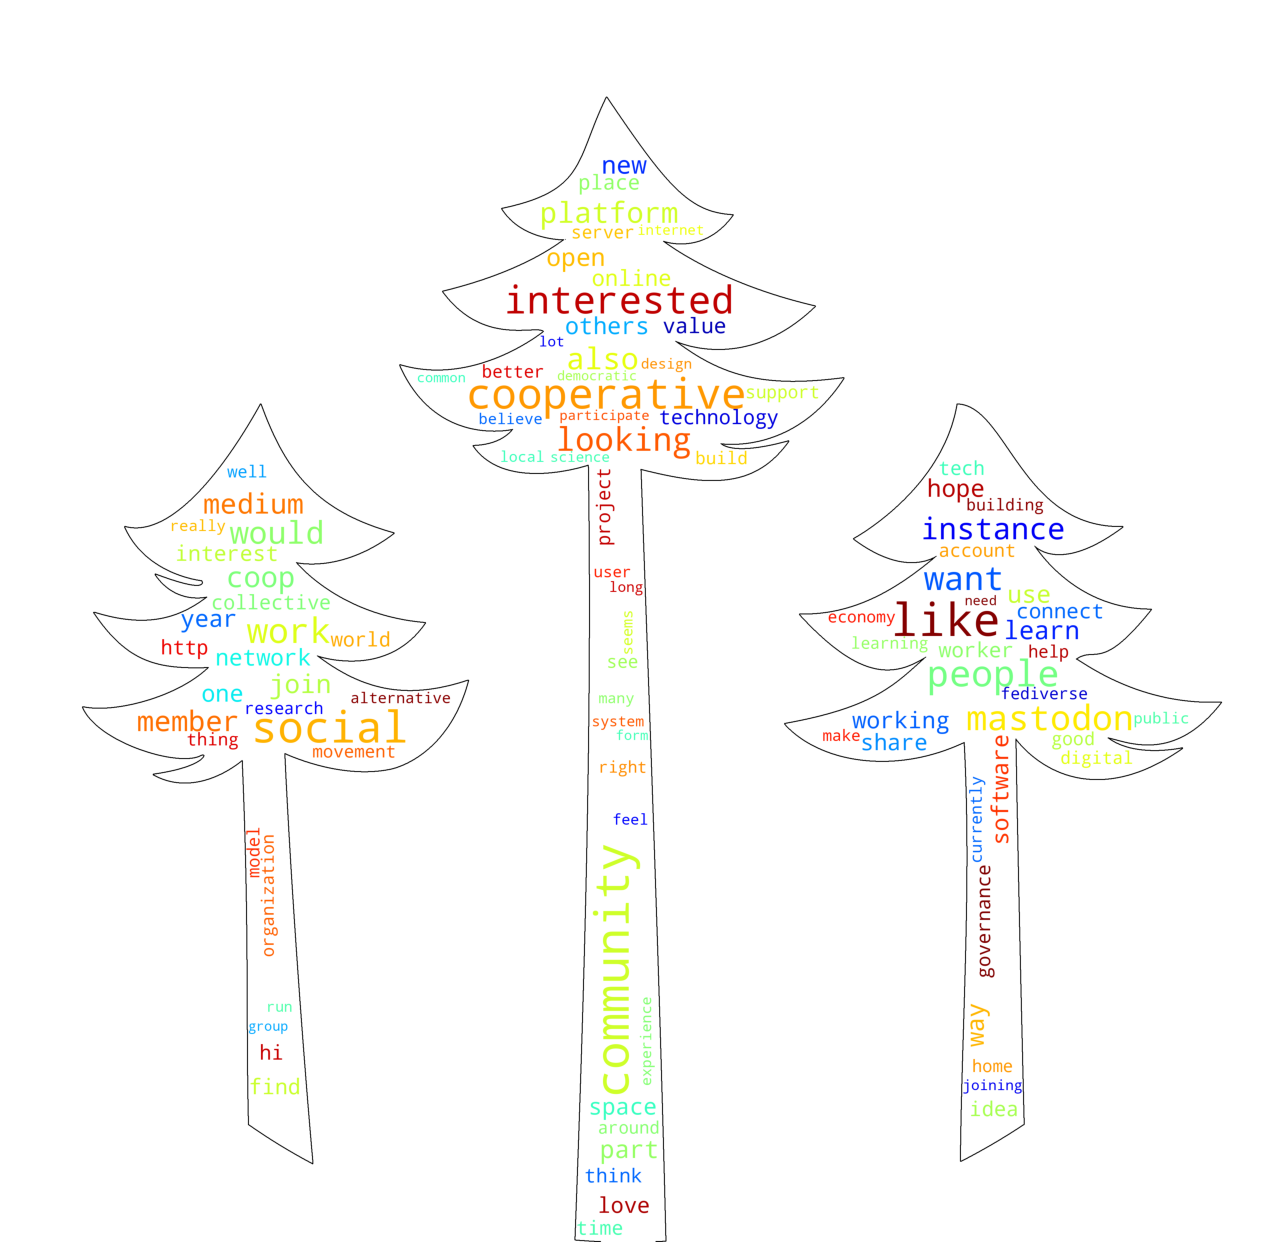

In [28]:
generate_basic_wordcloud(counts, mask=mask, max_words=100, contour_width=2, colormap='jet')